In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# %load main_multioutput.py
#!/usr/bin/env python3
# Copyright (C) 2018 ZIHENG WANG: zihengwang@utdallas.edu, Rafe McBeth rafe.mcbeth@utsouthwestern.edu
import numpy as np
import pandas as pd
import os

from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from keras import layers, optimizers
from keras.models import Model, Input
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt

import itertools

/home/rafe/Apps/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
root_dir = os.getcwd ()
data_dir = root_dir + '/data'
label_dir = root_dir + '/label'
results_dir = root_dir + '/results'

colName = ['bckt', 'Sys BP', 'MAP', 'Dia BP', 'CVP', 'Heart Rate', 'Resp Rate',
           'SpO2', 'Temp', 'Pressure PostOxygenator', 'Pressure PreOxygenator',
           'Pressure Volume Sensor', 'Sweep FiO2', 'Measured Flow', 'Total Sweep',
           'pH', 'pO2', 'pCO2', 'Base Excess', 'ALT', 'AST', 'Creatinine',
           'Hematocrit', 'Hemoglobin', 'Free Hemoglobin', 'INR', 'PT', 'PTT',
           'Platelet', 'Fibrinogen', 'Glucose', 'Lactate', 'Unfrac Heparin',
           'Total Bilirubin', 'ACT Kaolin', 'epinephrine', 'fentanyl', 'heparin',
           'midazolam', 'paralytics']

In [5]:
# import raw data into dict: mapDatabyUserName by patient name
mapDatabyUserName = {}
mapBcktbyUserName = {}
list = []
for _, _, file_list in os.walk (data_dir + '/'):
    file_list = [file for file in file_list if file.endswith ('.csv')]
    for file in file_list:

        userName = int (file.split ('.csv')[0].strip ('pt_'))
        rawData = pd.read_csv (data_dir + '/' + file, delimiter=',')

        mapBcktbyUserName[userName] = rawData['bckt'].values

        if 'bckt' not in rawData.keys ().tolist ():
            print (userName)
        # rawData = rawData[rawData['bckt']>=0]
        rawData = rawData.drop (['bckt'], axis=1)

        print ('importing data: {}, shape:{}'.format (userName, rawData.values.shape))
        mapDatabyUserName[userName] = rawData.values

# import label to dict: mapLabelbyUserName by patient name        
df_label = pd.read_csv (label_dir + '/label.csv')
mapLabelbyUserName = {}
for i in range (len (df_label['studyid'])):
    mapLabelbyUserName[df_label['studyid'][i]] = [df_label['Any Injury'][i], df_label['Bleed'][i],
                                                  df_label['Infarct'][i]]

importing data: 113, shape:(88, 23)
importing data: 51, shape:(176, 23)
importing data: 3, shape:(122, 23)
importing data: 39, shape:(547, 23)
importing data: 25, shape:(93, 23)
importing data: 5, shape:(99, 23)
importing data: 60, shape:(214, 23)
importing data: 11, shape:(146, 23)
importing data: 30, shape:(159, 23)
importing data: 73, shape:(429, 23)
importing data: 117, shape:(100, 23)
importing data: 52, shape:(175, 23)
importing data: 40, shape:(115, 23)
importing data: 124, shape:(446, 23)
importing data: 115, shape:(108, 23)
importing data: 4, shape:(329, 23)
importing data: 33, shape:(108, 23)
importing data: 112, shape:(100, 23)
importing data: 106, shape:(68, 23)
importing data: 122, shape:(127, 23)
importing data: 109, shape:(257, 23)
importing data: 16, shape:(165, 23)
importing data: 91, shape:(61, 23)
importing data: 13, shape:(82, 23)
importing data: 80, shape:(131, 23)
importing data: 104, shape:(338, 23)
importing data: 24, shape:(101, 23)
importing data: 118, shape:(

In [6]:
EPOCH = 250
BATCH_SIZE = 200

#seq_len = np.arange(1,12)
seq_len = 4
#seq_len = [2,4,6,8,10,12]
seq_dim = mapDatabyUserName[1].shape[1]

step_size = seq_len / 3

n_class = 2

input_shape = [seq_len, seq_dim]
output_shape = n_class

learning_rate = 0.001

In [7]:
def getWindowSlides (x):
    # make to matrix
    n = len (x)
    X = np.array ([x[i:i + seq_len] for i in np.arange (0, (n - seq_len), step_size, dtype=int)])
    return X

In [8]:
X_train = []
X_val = []
X_test = []

Y_train = []
Y_val = []
Y_test = []

X = []
Y1 = []
Y2 = []
Y3 = []

temp_X = []
temp_Y1 = []
temp_Y2 = []
temp_Y3 = []
for user in mapDatabyUserName.keys ():
    x = mapDatabyUserName[user]
    y1 = mapLabelbyUserName[user][0]
    y2 = mapLabelbyUserName[user][1]
    y3 = mapLabelbyUserName[user][2]

    if x.shape[0] < seq_len:
        print ('User {} data length {} less than size of the window'.format (user, x.shape[0]))

    slides_x = getWindowSlides (x)
    slides_y1 = np.tile (y1, [len (slides_x), 1])
    slides_y2 = np.tile (y2, [len (slides_x), 1])
    slides_y3 = np.tile (y3, [len (slides_x), 1])

    temp_X.append (slides_x)
    temp_Y1.append (slides_y1)
    temp_Y2.append (slides_y2)
    temp_Y3.append (slides_y3)
X = np.concatenate (temp_X, axis=0)  # dont put vstack in loop, instead using list.append, np.vstack(list)
Y1 = np.vstack (temp_Y1)
Y2 = np.vstack(temp_Y2)
Y3 = np.vstack(temp_Y3)

# one hot encoding labels
Y1 = to_categorical (Y1, n_class)
Y2 = to_categorical (Y2, n_class)
Y3 = to_categorical (Y3, n_class)

In [9]:
# split training and testing data, seqence shape: [~, seq_len, seq_dim]
X_tr, X_test, Y1_tr, Y1_test, Y2_tr, Y2_test, Y3_tr, Y3_test = train_test_split (X, Y1, Y2, Y3, test_size=0.2, random_state=123)

# further split training data into train/validication set for modeling
size = int(X_tr.shape[0]*.2) 
X_train = X_tr[:-size, :, :]
Y1_train = Y1_tr[:-size, :]
Y2_train = Y2_tr[:-size, :]
Y3_train = Y3_tr[:-size, :]

X_val = X_tr[-size:, :, :]
Y1_val = Y1_tr[-size:, :]
Y2_val = Y2_tr[-size:, :]
Y3_val = Y3_tr[-size:, :]


3151
(3151, 2)


In [16]:
# parallel deep model combining convolutional neural network and recurrent neural network
# reference1: Wang, Ziheng & Majewicz Fey, Ann. (2018). Deep Learning with Convolutional Neural Network for Objective Skill Evaluation in Robot-assisted Surgery. 2018, International Journal of Computer Assisted Radiology and Surgery. DOI: 10.1007/s11548-018-1860-1
# reference2: Wang, Ziheng & Majewicz Fey, Ann. (2018). SATR-DL: Improving Surgical Skill Assessment and Task Recognition in Robot-assisted Surgery with Deep Neural Networks. 2018, IEEE International Engineering in Medicine and Biology Conference.

def getModel (input_tensor, learning_rate):
    # branch A
    conv1 = layers.Conv1D (filters= 4, kernel_size=2, strides=1, padding='same',
                           kernel_initializer='glorot_uniform',
                           activation='relu', name='conv1') (input_tensor)
    bn1 = layers.BatchNormalization (name='bn1') (conv1)
    dropout1 = layers.Dropout (rate=0.2,name='dp1')(bn1)

    conv2 = layers.Conv1D(filters= 6, kernel_size=2, strides=1, padding='same',
                          kernel_initializer='glorot_uniform',
                          activation='relu', name='conv2')(dropout1)
    bn2 = layers.BatchNormalization(name='bn2')(conv2)
    dropout2 = layers.Dropout(rate=0.2, name='dp2')(bn2)
    ft1 = layers.Flatten () (dropout2)

    # branch B
    lstm1 = layers.GRU(12, return_sequences=True, kernel_initializer='glorot_uniform', activation='relu', dropout=0.2, name='gru1')(
                input_tensor)
    lstm2 = layers.GRU(8, return_sequences=False, kernel_initializer='glorot_uniform', activation='relu', dropout=0.2, name='gru2')(
                lstm1)

    # fusion features from CNN and RNN
    fusion = layers.Concatenate (axis=1) ([ft1, lstm2])

    output1_tensor = layers.Dense (units=n_class, activation='softmax', name ='dense1') (fusion)
    output2_tensor = layers.Dense (units=n_class, activation='softmax', name ='dense2') (fusion)
    output3_tensor = layers.Dense (units=n_class, activation='softmax', name ='dense3') (fusion)

    model = Model (input_tensor, [output1_tensor, output2_tensor, output3_tensor])
    optimizer = optimizers.Adam (lr=learning_rate)
    model.compile (optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
    return model


""" loss plot """
def plot_loss(epochs, loss, val_loss, class_category = None):
    plt.plot(epochs, loss, '--', label= 'Training Loss',lw =2)
    plt.plot(epochs, val_loss, '-', label= 'Validation Loss',lw =2)
    plt.title('training and validation loss - {}'.format(class_category), fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout ()


""" accuracy plot """
def plot_accuracy(epochs, acc, val_acc, class_category = None):
    plt.plot (epochs, acc, '--', label='Training Accuracy', lw=2)
    plt.plot (epochs, val_acc, '-', label='Validation Accuracy', lw=2)
    plt.title ('training and validation accuracy - {}'.format(class_category), fontsize=18)
    plt.xlabel ('Epochs', fontsize=14)
    plt.ylabel ('Accuracy', fontsize=14)
    plt.legend (fontsize=12)
    plt.tight_layout ()
    

""" confusion matrix plot """
def plot_confusion_matrix(cm, classes,normalize=False,
                         title='Confusion matrix',
                      cmap=plt.cm.PuBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')    
        print(cm)    
    plt.title(title, fontsize = 16)    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.clim(0, 1)
    plt.ylabel('True label', fontsize =12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.tight_layout ()

In [11]:
input_tensor = Input (shape=(seq_len, seq_dim))
model = getModel (input_tensor, learning_rate)
history = model.fit (X_train, [Y1_train, Y2_train, Y3_train], epochs=EPOCH, batch_size=BATCH_SIZE,
                     validation_data=(X_val, [Y1_val, Y2_val, Y3_val]))


Train on 12607 samples, validate on 3151 samples
Epoch 1/250
12607/12607 [==============================] - 3s 204us/step - loss: 2.4560 - dense1_loss: 0.7830 - dense2_loss: 0.7146 - dense3_loss: 0.9584 - dense1_acc: 0.5349 - dense2_acc: 0.6384 - dense3_acc: 0.6687 - val_loss: 1.9597 - val_dense1_loss: 0.6764 - val_dense2_loss: 0.5615 - val_dense3_loss: 0.7218 - val_dense1_acc: 0.5862 - val_dense2_acc: 0.7839 - val_dense3_acc: 0.6998
Epoch 2/250
12607/12607 [==============================] - 1s 43us/step - loss: 2.0029 - dense1_loss: 0.7164 - dense2_loss: 0.5913 - dense3_loss: 0.6953 - dense1_acc: 0.5737 - dense2_acc: 0.7586 - dense3_acc: 0.6972 - val_loss: 1.7356 - val_dense1_loss: 0.6628 - val_dense2_loss: 0.5160 - val_dense3_loss: 0.5568 - val_dense1_acc: 0.5992 - val_dense2_acc: 0.7912 - val_dense3_acc: 0.7153
Epoch 3/250
12607/12607 [==============================] - 1s 44us/step - loss: 1.8236 - dense1_loss: 0.6939 - dense2_loss: 0.5520 - dense3_loss: 0.5776 - dense1_acc: 0.5911 

In [34]:
history.history.keys()

dict_keys(['val_loss', 'val_dense1_loss', 'val_dense2_loss', 'val_dense3_loss', 'val_dense1_acc', 'val_dense2_acc', 'val_dense3_acc', 'loss', 'dense1_loss', 'dense2_loss', 'dense3_loss', 'dense1_acc', 'dense2_acc', 'dense3_acc'])

****************************************
Optimization Finished!


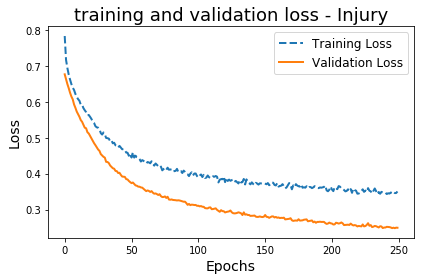

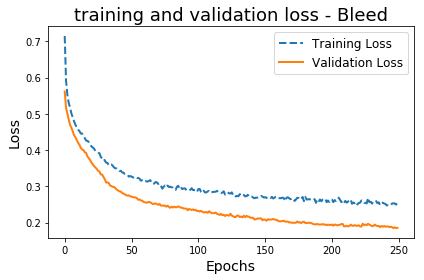

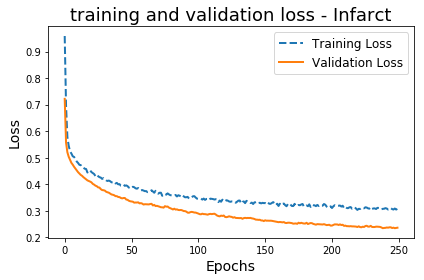

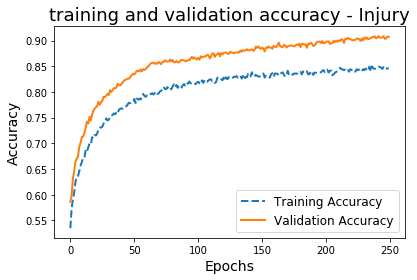

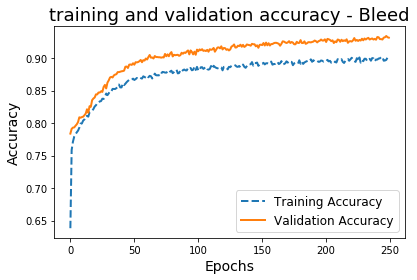

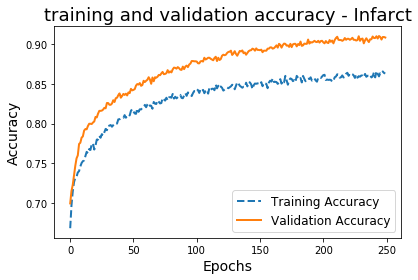

In [83]:
""" prediction and visualize results"""
cat1 = 'Injury'
cat2 = 'Bleed'
cat3 = 'Infarct'

# save training/validation history
pd.DataFrame (history.history).to_csv (results_dir + '/' + 'history_seqlen_{}'.format (seq_len) + '.csv')

##################################################
# save loss1 - injury
loss1 = history.history['dense1_loss']
val_loss1 = history.history['val_dense1_loss']
# save loss2 - bleeding
loss2 = history.history['dense2_loss']
val_loss2 = history.history['val_dense2_loss']
# save loss3 - Infarct
loss3 = history.history['dense3_loss']
val_loss3 = history.history['val_dense3_loss']

# save loss plot
plt.figure ()
plot_loss (history.epoch, loss1, val_loss1, class_category = cat1)
plt.savefig (os.path.join (results_dir + '/' + 'class_' + cat1 + '_loss_seqlen_{}'.format (seq_len) + '.pdf'),
             bbox_inches="tight")
plt.figure ()
plot_loss (history.epoch, loss2, val_loss2, class_category = cat2)
plt.savefig (os.path.join (results_dir + '/' + 'class_' + cat2 + '_loss_seqlen_{}'.format (seq_len) + '.pdf'),
             bbox_inches="tight")
plt.figure ()
plot_loss (history.epoch, loss3, val_loss3, class_category = cat3)
plt.savefig (os.path.join (results_dir + '/' + 'class_' + cat3+ '_loss_seqlen_{}'.format (seq_len) + '.pdf'),
             bbox_inches="tight")

##################################################
# save acc1 - injury
acc1 = history.history['dense1_acc']
val_acc1 = history.history['val_dense1_acc']
# save acc2 - bleeding
acc2 = history.history['dense2_acc']
val_acc2 = history.history['val_dense2_acc']
# save acc3 - Infarct
acc3 = history.history['dense3_acc']
val_acc3 = history.history['val_dense3_acc']

# save accuracy plot
plt.figure ()
plot_accuracy (history.epoch, acc1, val_acc1,class_category = cat1)
plt.savefig (os.path.join (results_dir + '/' + 'class_' + cat1 + '_acc_seqlen_{}'.format (seq_len) + '.pdf'),
             bbox_inches="tight")

plt.figure ()
plot_accuracy (history.epoch, acc2, val_acc2,class_category = cat2)
plt.savefig (os.path.join (results_dir + '/' + 'class_' + cat2 + '_acc_seqlen_{}'.format (seq_len) + '.pdf'),
             bbox_inches="tight")

plt.figure ()
plot_accuracy (history.epoch, acc3, val_acc3,class_category = cat3)
plt.savefig (os.path.join (results_dir + '/' + 'class_' + cat3 + '_acc_seqlen_{}'.format (seq_len) + '.pdf'),
             bbox_inches="tight")


    
##################################################
print ('*'*40)
print ('Optimization Finished!')


In [62]:
# evaluate on hold-out test data
score = model.evaluate(X_test, [Y1_test,Y2_test,Y3_test], verbose=0)
print(score)

print('[Test] injury_loss:', score[1])
print('[Test] injury_accuracy:', score[-3])

print('[Test] bleed_loss:', score[2])
print('[Test] bleed_accuracy:', score[-2])

print('[Test] infarct_loss:', score[3])
print('[Test] infarct_accuracy:', score[-1])

[0.6815416303988036, 0.24804707901731965, 0.1835934647826979, 0.2499010878619809, 0.9015228426395939, 0.932233502538071, 0.8984771573604061]
Test loss: 0.6815416303988036
Test accuracy: 0.24804707901731965


In [63]:
# get prediction on hold-out test data
[Y1_test_predict, Y2_test_predict, Y3_test_predict] = model.predict(X_test)
Y1_test_predict = np.argmax(Y1_test_predict,axis=1) # convert one-hot encoded vector into 1d vector 
Y2_test_predict = np.argmax(Y2_test_predict,axis=1) # convert one-hot encoded vector into 1d vector 
Y3_test_predict = np.argmax(Y3_test_predict,axis=1) # convert one-hot encoded vector into 1d vector 
print(Y1_test_predict.shape)
print(Y2_test_predict.shape)
print(Y3_test_predict.shape)

(3940,)
[0 1 0 ... 0 0 1]
(3940,)
(3940,)


Normalized confusion matrix


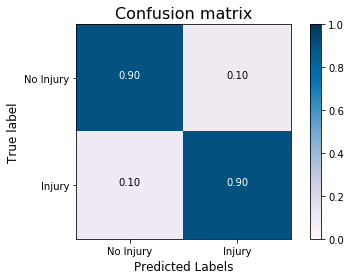

In [79]:
# calculate/plot confusion matrix - injury
confusion_matrix1 = metrics.confusion_matrix(np.argmax(Y1_test,axis=1), Y1_test_predict)
plt.figure()
plot_confusion_matrix(confusion_matrix1, classes=['No Injury','Injury'],normalize=True)
plt.savefig(os.path.join(results_dir + '/confusionmat_Injury_seqlen_{}'.format(seq_len)+ '.pdf'), bbox_inches="tight")

Normalized confusion matrix


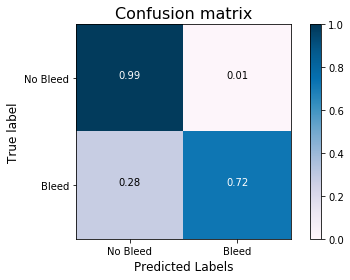

In [80]:
# calculate/plot confusion matrix - bleeding
confusion_matrix2 = metrics.confusion_matrix(np.argmax(Y2_test,axis=1), Y2_test_predict)
plt.figure()
plot_confusion_matrix(confusion_matrix2, classes=['No Bleed','Bleed'],normalize=True)
plt.savefig(os.path.join(results_dir + '/confusionmat_Bleed_seqlen_{}'.format(seq_len)+ '.pdf'), bbox_inches="tight")

Normalized confusion matrix


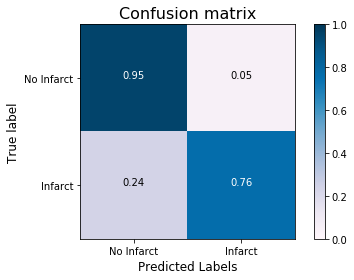

In [81]:
# calculate/plot confusion matrix - infarct
confusion_matrix3 = metrics.confusion_matrix(np.argmax(Y3_test,axis=1), Y3_test_predict)
plt.figure()
plot_confusion_matrix(confusion_matrix3, classes=['No Infarct','Infarct'],normalize=True)
plt.savefig(os.path.join(results_dir + '/confusionmat_Infarct_seqlen_{}'.format(seq_len)+ '.pdf'), bbox_inches="tight")